<a href="https://colab.research.google.com/github/julianovale/PO240_Meta_heuristica/blob/main/PO240_TrabalhoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colônia de Formigas

In [1]:
############################################################################

# Created by: Prof. Valdecy Pereira, D.Sc.
# UFF - Universidade Federal Fluminense (Brazil)
# email:  valdecy.pereira@gmail.com
# Course: Metaheuristics
# Lesson: Ant Colony Optimization

# Citation: 
# PEREIRA, V. (2018). Project: Metaheuristic-Ant_Colony_Optimization, File: Python-MH-Ant Colony Optimization.py, GitHub repository: <https://github.com/Valdecy/Metaheuristic-Ant_Colony_Optimization>

############################################################################


import pandas as pd
import random
import numpy  as np
import copy
import os
from matplotlib import pyplot as plt 
import time 

# Function: Tour Distance
def distance_calc(Xdata, city_tour):
    distance = 0
    for k in range(0, len(city_tour[0])-1):
        m = k + 1
        distance = distance + Xdata[city_tour[0][k]-1, city_tour[0][m]-1]            
    return distance

# Function: Euclidean Distance 
def euclidean_distance(x, y):       
    distance = 0
    for j in range(0, len(x)):
        distance = (x[j] - y[j])**2 + distance   
    return distance**(1/2) 

# Function: Build Distance Matrix
def buid_distance_matrix(coordinates):
    Xdata = np.zeros((coordinates.shape[0], coordinates.shape[0]))
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            if (i != j):
                x = coordinates[i,:]
                y = coordinates[j,:]
                Xdata[i,j] = euclidean_distance(x, y)        
    return Xdata

# Function: Tour Plot
def plot_tour_distance_matrix(Xdata, city_tour):
    m = np.copy(Xdata)
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            m[i,j] = (1/2)*(Xdata[0,j]**2 + Xdata[i,0]**2 - Xdata[i,j]**2)    
    w, u = np.linalg.eig(np.matmul(m.T, m))
    s = (np.diag(np.sort(w)[::-1]))**(1/2) 
    coordinates = np.matmul(u, s**(1/2))
    coordinates = coordinates.real[:,0:2]
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Initial Attractiveness
def attractiveness(Xdata):
    h = np.zeros((Xdata.shape[0], Xdata.shape[0]))  
    for i in range(0, Xdata.shape[0]):
        for j in range(0, Xdata.shape[1]):
            if (i == j or Xdata[i,j] == 0):
                h[i, j] = 0.000001
            else:
                h[i, j] = 1/Xdata[i,j]   
    return h

# Function: Tour Plot
def plot_tour_coordinates(coordinates, city_tour):
    xy = np.zeros((len(city_tour[0]), 2))
    for i in range(0, len(city_tour[0])):
        if (i < len(city_tour[0])):
            xy[i, 0] = coordinates[city_tour[0][i]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][i]-1, 1]
        else:
            xy[i, 0] = coordinates[city_tour[0][0]-1, 0]
            xy[i, 1] = coordinates[city_tour[0][0]-1, 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return

# Function: Probability Matrix 
def city_probability(h, thau, city = 0, alpha = 1, beta = 2, city_list = []):
    probability = np.zeros((h.shape[0], 3)) # ['atraction','probability','cumulative_probability']
    for i in range(0, probability.shape[0]):
        if (i+1 not in city_list):
            probability[i, 0] = (thau[i, city]**alpha)*(h[i, city]**beta)
    for i in range(0, probability.shape[0]):
        if (i+1 not in city_list and probability[:,0].sum() != 0):
            probability[i, 1] = probability[i, 0]/probability[:,0].sum()
        if (i == 0):
            probability[i, 2] =  probability[i, 1] 
        else:
            probability[i, 2] = probability[i, 1] + probability[i - 1, 2]     
    if (len(city_list) > 0):
        for i in range(0, len(city_list)):
            probability[city_list[i]-1, 2] = 0.0            
    return probability

# Function: Select Next City
def city_selection(probability_matrix, city_list = []):
    random = int.from_bytes(os.urandom(8), byteorder = "big") / ((1 << 64) - 1)
    city = 0
    for i in range(0, probability_matrix.shape[0]):
        if (random <= probability_matrix[i, 2] and i+1 not in city_list):
          city = i+1
          break     
    return city

# Function: Update Thau
def update_thau(Xdata, thau, city_list = []):
    distance = 0
    for i in range(0, len(city_list)-1):
        j = i + 1
        distance = distance + Xdata[city_list[i]-1,city_list[j]-1] 
    pheromone = 1  
    for i in range(0, len(city_list)-1):
        j = i + 1 
        thau[city_list[i]-1,city_list[j]-1] = thau[city_list[i]-1,city_list[j]-1] + pheromone        
    return thau

# Function: 2_opt
def local_search_2_opt(Xdata, city_tour, recursive_seeding = -1):
    if (recursive_seeding < 0):
        count = -2
    else:
        count = 0
    city_list_new = copy.deepcopy([city_tour[0]])
    city_list_new.append(city_tour[1])
    city_list_old = city_list_new[1]*2
    iteration = 0
    while (count < recursive_seeding):
        best_route = copy.deepcopy(city_list_new)
        seed = copy.deepcopy(city_list_new)        
        for i in range(0, len(city_list_new[0]) - 2):
            for j in range(i+1, len(city_list_new[0]) - 1):
                best_route[0][i:j+1] = list(reversed(best_route[0][i:j+1]))           
                best_route[0][-1]  = best_route[0][0]              
                best_route[1] = distance_calc(Xdata, best_route)                     
                if (city_list_new[1] > best_route[1]):
                    city_list_new = copy.deepcopy(best_route)         
                best_route = copy.deepcopy(seed)
        count = count + 1
        iteration = iteration + 1  
        if (city_list_old > city_list_new[1] and recursive_seeding < 0):
             city_list_old = city_list_new[1]
             count = -2
             recursive_seeding = -1
        elif(city_list_new[1] >= city_list_old and recursive_seeding < 0):
            count = -1
            recursive_seeding = -2
    return city_list_new[0], city_list_new[1]

# Function: Ants City List
def ants_path(Xdata, h, thau, alpha, beta, full_list, ants):
    distance           = np.sum(Xdata.sum())
    best_city_list     = []
    best_path_distance = []
    for ant in range(0, ants):
        city_list = []
        initial = random.randrange(1, Xdata.shape[0])
        city_list.append(initial)           
        for i in range(0, Xdata.shape[0] - 1):
            probability = city_probability(h, thau, city = i, alpha = alpha, beta = beta, city_list = city_list)
            path_point  = city_selection(probability, city_list = city_list)
            if (path_point == 0):
                path_point = [value for value in full_list if value not in city_list][0]
            city_list.append(path_point)
        city_list.append(city_list[0])
        path_distance = 0
        for i in range(0, len(city_list)-1):
            j = i + 1
            path_distance = path_distance + Xdata[city_list[i]-1,city_list[j]-1] 
        if (distance > path_distance):
            best_city_list     = copy.deepcopy(city_list)
            best_path_distance = path_distance
            distance           = path_distance
    best_route = copy.deepcopy([best_city_list])
    best_route.append(best_path_distance)
    best_city_list, best_path_distance = local_search_2_opt(Xdata, city_tour = best_route, recursive_seeding = -1)
    thau = update_thau(Xdata, thau, city_list = best_city_list)
    return best_city_list, best_path_distance, thau

# ACO Function
def ant_colony_optimization(Xdata, ants = 5, iterations = 50, alpha = 1, beta = 2, decay = 0.05): 
    inicio = time.time()
    count       = 0  
    best_route  = [] 
    full_list   = list(range(1, Xdata.shape[0] + 1))
    distance    = np.sum(Xdata.sum())
    h           = attractiveness(Xdata)
    thau        = np.ones((Xdata.shape[0], Xdata.shape[0]))  
    eixox = []
    eixoy = []
    while (count <= iterations):
        if (count > 0):
            print("Iteration = ", count, " -> Distance = ", best_route[1])
            eixox.append(count)
            eixoy.append(best_route[1])            
        city_list, path_distance, thau = ants_path(Xdata, h, thau, alpha, beta, full_list, ants)
        thau = thau*(1 - decay)
        if (distance > path_distance):
            best_route = copy.deepcopy([city_list])
            best_route.append(path_distance)
            distance = best_route[1]
        count = count + 1  

    fim = time.time()  
    print("Tempo de execução (s): ", fim - inicio)  
    print("Melhor rota: ", best_route)       
    return  best_route, eixox, eixoy

# Simulated Annealing

In [2]:
###################################################################################################

#  Algoritmo desenvolvido por Juliano Vale e Matheus Evangelista
#  Baseado em aula de otimização para função contínua (função de Himmelblau) do curso "Optimization  
#  with metaheuristics in Python" - Profa. Dana Bani-Hani - Binghamton University (NY - USA)
#  https://www.udemy.com/course/optimization-with-metaheuristics/

###################################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

# função copiada de https://github.com/Valdecy/Summary
def caminho(coordinates, city_tour):
    xy = np.zeros((len(city_tour), 2))
    for i in range(0, len(city_tour)):
        if (i < len(city_tour)):
            xy[i, 0] = coordinates[int(city_tour[i]-1), 0]
            xy[i, 1] = coordinates[int(city_tour[i]-1), 1]
        else:
            xy[i, 0] = coordinates[int(city_tour[0]-1), 0]
            xy[i, 1] = coordinates[int(city_tour[0]-1), 1]
    plt.plot(xy[:,0], xy[:,1], marker = 's', alpha = 1, markersize = 7, color = 'black')
    plt.plot(xy[0,0], xy[0,1], marker = 's', alpha = 1, markersize = 7, color = 'red')
    plt.plot(xy[1,0], xy[1,1], marker = 's', alpha = 1, markersize = 7, color = 'orange')
    return


# função copiada de https://developers.google.com/optimization/routing/tsp
# Essa função é interessante para placa de circuito impresso, trabalha com espaço plano. NÃO USAR PARA CIDADES!!!
# para cidades utilizar alguma função de geocodificação
def compute_euclidean_distance_matrix(locations): 
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                               (from_node[1] - to_node[1]))))
    return distances


def SA(coordenadas, T0 = 1000, M = 250, N = 5, Alpha = 0.9):

  df = pd.read_csv(coordenadas)
  Y = df.values

  distancias = compute_euclidean_distance_matrix(Y)

  teste1 = pd.DataFrame.from_dict(distancias, orient='index')

  Data1 = teste1

  
  # X0 = [6, 7, 8, 9, 14, 18, 21, 20, 22, 23, 24, 19, 13, 17, 16, 15, 10, 12, 11, 3, 2, 1, 0, 4, 5, 6]
  X0 = np.arange(len(teste1)).tolist() # solução inicial aleatória
  X0 = random.sample(X0, len(X0))
  X0.append(X0[0])
  print(X0)

  ### NÃO SÃO MAIS CIDADES... SÃO PONTOS NA PLACA DE CIRCUITO IMPRESSO: TROCAR NOME DAS VARIÁVEIS? NÃO PRECISA!

  Distances = [] 
  t = 0
  for i in range(len(X0)-1):
      X1 = Data1.loc[X0[t],X0[t+1]] # cada localidade e a localidade após
      X11 = Data1.loc[X0[-1],X0[0]] # a útlima cidade para a primeira cidade
      Distances.append(X1) 
      t = t+1

  Distances.append(X11) # adiciona o últino trajeto 
  distanciainicial = sum(Distances) # soma das distâncias

  print("Solução inicial: ", distanciainicial)

  ### parametros ### Já pus na def, comentar

  # T0 = 3000
  # M = 1000
  # N = 50
  # Alpha = 0.85

  TempIni = T0 # para impressão do gráfico final

  # Para gerar visualização
  Temp = []
  Min_Distance = []


  for i in range(M):
      for j in range(N):
          # Gerando inteiros para fazer a troca de "cidades"
          Ran1 = np.random.randint(0,len(X0))
          Ran2 = np.random.randint(0,len(X0))
          while Ran1 == Ran2:
              Ran2 = np.random.randint(0,len(X0))
          
          Xtemp = []
          A1 = X0[Ran1] # cidade 1 para trocar
          A2 = X0[Ran2] # cidade 2 para trocar
          
          # Fazendo uma nova lista de cidades
          w = 0
          for i in X0:
              if X0[w]==A1:
                  Xtemp=np.append(Xtemp,A2)
              elif X0[w]==A2:
                  Xtemp=np.append(Xtemp,A1)
              else:
                  Xtemp=np.append(Xtemp,X0[w])
              w = w+1
          
          Xtemp = list(Xtemp)
          
          Distances_X0 = [] # a função objetivo da atual solução
          t = 0
          for i in range(len(X0)-1):
              X1_1 = Data1.loc[X0[t],X0[t+1]] 
              X11 = Data1.loc[X0[-1],X0[0]] 
              Distances_X0.append(X1_1) 
              t = t+1
          
          Distances_X0.append(X11) 
          Len_X0 = sum(Distances_X0) 
          
          ### Esse trecho do código está repetitivo... criar uma def (se der tempo!!!)
          Distances_Xtemp = [] # A FO da solução (n+1)
          t = 0 
          for i in range(len(Xtemp)-1):
              X1_2 = Data1.loc[Xtemp[t],Xtemp[t+1]] 
              X11 = Data1.loc[Xtemp[-1],Xtemp[0]] 
              Distances_Xtemp.append(X1_2) 
              t = t+1
          
          Distances_Xtemp.append(X11)
          Len_Xtemp = sum(Distances_Xtemp)
          
          
          rand_num = np.random.rand() # cria um número aleatório 
          form_1 = 1/(np.exp((Len_Xtemp-Len_X0)/T0)) # o pulo do gato (no código anterior não funcionava): ACEITA MUDANÇA?
          
          if Len_Xtemp <= Len_X0: # se a solução potencial é melhor (menor, no caso)
              X0 = Xtemp
          
          elif rand_num <= form_1: # se o número aleatório gerado na linha 118 for menor.
              X0 = Xtemp
          
          else: # não aceita a potencial solução e fica onde está
              X0 = X0
              
      Temp = np.append(Temp, T0) # para visualização
      Min_Distance = np.append(Min_Distance,Len_Xtemp) # para visualização
      
      T0 = Alpha*T0 # reduz a temperatura
      
      
      
      
      

  print
  print
  print("Solução final: ", X0)
  print("A distância obtida na solução final é: ", Len_X0)
  print
  print

  eixox = np.arange(1, TempIni+1, TempIni/M)
  eixox[::-1]
  plt.plot(eixox, Min_Distance)
  plt.title('Distância x Temperatura')
  plt.xlabel("Temperatura")
  plt.ylabel("Distância")
  plt.show()

  return X0

# Instância 1: Vox Treble Booster - Colônia de Formigas




Iteration =  1  -> Distance =  36.616020898215645
Iteration =  2  -> Distance =  36.616020898215645
Iteration =  3  -> Distance =  36.58696084529313
Iteration =  4  -> Distance =  36.58696084529313
Iteration =  5  -> Distance =  36.58696084529313
Iteration =  6  -> Distance =  36.58696084529313
Iteration =  7  -> Distance =  36.58696084529313
Iteration =  8  -> Distance =  35.15298244508295
Iteration =  9  -> Distance =  35.15298244508295
Iteration =  10  -> Distance =  35.15298244508295
Iteration =  11  -> Distance =  35.15298244508295
Iteration =  12  -> Distance =  35.15298244508295
Iteration =  13  -> Distance =  35.15298244508295
Iteration =  14  -> Distance =  35.15298244508295
Iteration =  15  -> Distance =  35.15298244508295
Iteration =  16  -> Distance =  35.15298244508295
Iteration =  17  -> Distance =  35.15298244508295
Iteration =  18  -> Distance =  35.15298244508295
Iteration =  19  -> Distance =  35.15298244508295
Iteration =  20  -> Distance =  35.15298244508295
Iterati

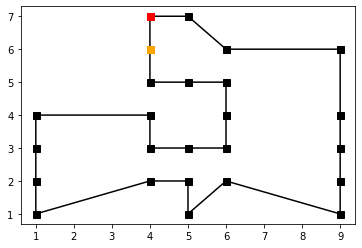

In [3]:
%%time
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/VoxTrebleBosster.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco, x, y = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

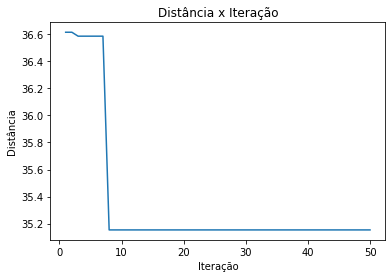

In [4]:
plt.plot(x,y)
plt.title('Distância x Iteração')
plt.xlabel("Iteração")
plt.ylabel("Distância")
plt.show()

# Instância 1: Vox Treble Booster - Simulated Annealing

[11, 15, 20, 23, 3, 19, 13, 4, 9, 22, 5, 7, 16, 8, 14, 6, 24, 12, 18, 21, 17, 10, 2, 0, 1, 11]
Solução inicial:  84


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in double_scalars


Solução final:  [10.0, 0.0, 1.0, 2.0, 3.0, 7.0, 6.0, 5.0, 11.0, 4.0, 12.0, 16.0, 17.0, 21.0, 20.0, 13.0, 19.0, 9.0, 14.0, 8.0, 18.0, 24.0, 23.0, 22.0, 15.0, 10.0]
A distância obtida na solução final é:  43


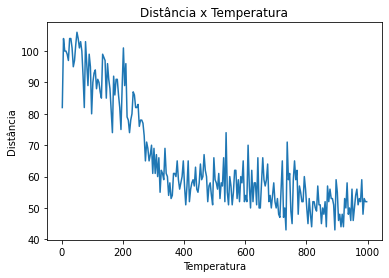

CPU times: user 5.21 s, sys: 55.5 ms, total: 5.27 s
Wall time: 5.28 s


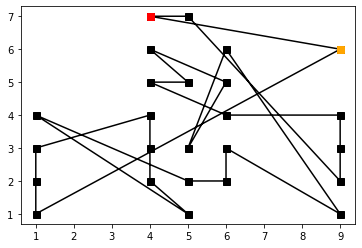

In [5]:
%%time
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/VoxTrebleBosster.txt'
sa = SA(url)
df = pd.read_csv(url)
Y = df.values
caminho(Y, sa)

# Instância 2 - Echoplex Preamp (31 pontos)

Iteration =  1  -> Distance =  40.64098632478745
Iteration =  2  -> Distance =  40.64098632478745
Iteration =  3  -> Distance =  40.64098632478745
Iteration =  4  -> Distance =  40.64098632478745
Iteration =  5  -> Distance =  40.64098632478745
Iteration =  6  -> Distance =  40.64098632478745
Iteration =  7  -> Distance =  40.64098632478745
Iteration =  8  -> Distance =  40.64098632478745
Iteration =  9  -> Distance =  40.24264068711928
Iteration =  10  -> Distance =  40.24264068711928
Iteration =  11  -> Distance =  40.24264068711928
Iteration =  12  -> Distance =  40.24264068711928
Iteration =  13  -> Distance =  40.24264068711928
Iteration =  14  -> Distance =  40.24264068711928
Iteration =  15  -> Distance =  40.24264068711928
Iteration =  16  -> Distance =  40.24264068711928
Iteration =  17  -> Distance =  40.24264068711928
Iteration =  18  -> Distance =  40.24264068711928
Iteration =  19  -> Distance =  40.24264068711928
Iteration =  20  -> Distance =  40.06449510224598
Iteration

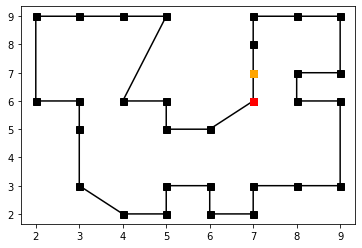

In [ ]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/EchoplexPreamp.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

# Instância 3 - RAT (70 pontos)

Iteration =  1  -> Distance =  105.61257247669084
Iteration =  2  -> Distance =  103.33936683936108
Iteration =  3  -> Distance =  103.33936683936108
Iteration =  4  -> Distance =  103.33936683936108
Iteration =  5  -> Distance =  98.4421705006364
Iteration =  6  -> Distance =  98.4421705006364
Iteration =  7  -> Distance =  98.4421705006364
Iteration =  8  -> Distance =  98.4421705006364
Iteration =  9  -> Distance =  98.4421705006364
Iteration =  10  -> Distance =  98.4421705006364
Iteration =  11  -> Distance =  97.47545795631281
Iteration =  12  -> Distance =  97.02795693826329
Iteration =  13  -> Distance =  97.02795693826329
Iteration =  14  -> Distance =  97.02795693826329
Iteration =  15  -> Distance =  97.02795693826329
Iteration =  16  -> Distance =  97.02795693826329
Iteration =  17  -> Distance =  97.02795693826329
Iteration =  18  -> Distance =  97.02795693826329
Iteration =  19  -> Distance =  97.02795693826329
Iteration =  20  -> Distance =  97.02795693826329
Iteration =

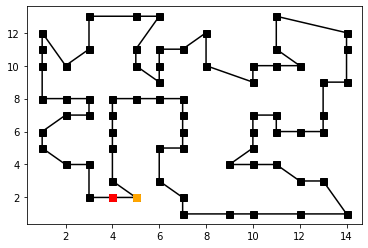

In [ ]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/RAT.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)

# Instância último - Blues Driver (157 pontos)

Iteration =  1  -> Distance =  228.61615997576297
Iteration =  2  -> Distance =  228.61615997576297
Iteration =  3  -> Distance =  228.61615997576297
Iteration =  4  -> Distance =  228.61615997576297
Iteration =  5  -> Distance =  228.61615997576297
Iteration =  6  -> Distance =  228.61615997576297
Iteration =  7  -> Distance =  228.61615997576297
Iteration =  8  -> Distance =  228.61615997576297
Iteration =  9  -> Distance =  228.61615997576297
Iteration =  10  -> Distance =  228.61615997576297
Iteration =  11  -> Distance =  228.61615997576297
Iteration =  12  -> Distance =  228.61615997576297
Iteration =  13  -> Distance =  228.61615997576297
Iteration =  14  -> Distance =  228.61615997576297
Iteration =  15  -> Distance =  225.81931769618672
Iteration =  16  -> Distance =  225.81931769618672
Iteration =  17  -> Distance =  225.81931769618672
Iteration =  18  -> Distance =  225.81931769618672
Iteration =  19  -> Distance =  225.81931769618672
Iteration =  20  -> Distance =  225.8193

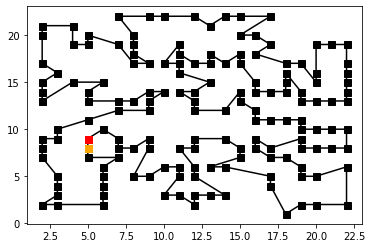

In [ ]:
url = 'https://raw.githubusercontent.com/julianovale/PO240_Meta_heuristica/main/TrabalhoFinal/Blues%20driver.txt'
df = pd.read_csv(url)
Y = df.values

X = buid_distance_matrix(Y)

aco = ant_colony_optimization(X, ants = 4, iterations = 50, alpha = 1, beta = 2, decay = 0.10)

plot_tour_coordinates(Y, aco)